# Compare annual-average trends between datasets




In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
import contextily as ctx
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import odc.geo.xr
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

plt.style.use('ggplot')

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters


In [2]:
model_var='NDVI'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/data/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'
crs='epsg:4326'
chunks=None#dict(latitude=1000, longitude=1000, time=1)
t_range='1982', '2022'

## Open data

In [3]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

ds = assign_crs(xr.open_dataset(ds_path, chunks=chunks)[model_var], crs='EPSG:4326')
ds = ds.sel(time=slice('1982','2013'))
ds.attrs['nodata'] = np.nan

#open original AVHRR
cdr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_NDVI_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
cdr = assign_crs(cdr, crs=crs)
cdr.attrs['nodata'] = np.nan

gimms_pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku = assign_crs(gimms_pku, crs=crs)
gimms_pku.attrs['nodata'] = np.nan

gimms_pku_cons = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku_cons = gimms_pku_cons.sel(time=slice('1982','2013'))
gimms_pku_cons = assign_crs(gimms_pku_cons, crs=crs)
gimms_pku_cons.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

#Open MODIS
modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis = modis.sel(time=slice('1982','2013'))
modis.attrs['nodata'] = np.nan

# #clip time lengths
# merge = merge.sel(time=slice('1982','2000-02'))
# avhrr = avhrr.sel(time=slice('1982','2000-02'))

In [4]:
cdr = cdr.odc.reproject(gimms_pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
gimms_pku_cons = gimms_pku_cons.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
modis = modis.odc.reproject(gimms_pku.odc.geobox, resampling='average')
ds = ds.odc.reproject(gimms_pku.odc.geobox, resampling='average')

gimms_pku = round_coords(gimms_pku)
gimms_pku_cons = round_coords(gimms_pku_cons)
cdr = round_coords(cdr)
gimms = round_coords(gimms)
modis = round_coords(modis)
ds = round_coords(ds)

In [5]:
gimms_mask =  ~np.isnan(gimms)
del gimms_mask.attrs['nodata']
gimms_mask = assign_crs(gimms_mask, crs=crs)

gimms_mask_cons =  ~np.isnan(gimms_pku_cons)
del gimms_mask_cons.attrs['nodata']
gimms_mask_cons = assign_crs(gimms_mask_cons, crs=crs)

cdr_mask =  ~np.isnan(cdr)
del cdr_mask.attrs['nodata']
cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(gimms_pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

#combine masks
mask = (gimms_mask & cdr_mask & pku_mask & gimms_mask_cons)

In [6]:
gimms_pku = gimms_pku.where(mask)
gimms = gimms.where(mask)
cdr = cdr.where(mask)
gimms_pku_cons = gimms_pku_cons.where(mask)
ds = ds.where(mask)
modis = modis.where(mask.sel(time=modis.time))

## 1D annual time-series

In [7]:
ds_1d = ds.resample(time='YS').mean().mean(['latitude', 'longitude'])
gimms_1d = gimms.resample(time='YS').mean().mean(['latitude', 'longitude'])
cdr_1d = cdr.resample(time='YS').mean().mean(['latitude', 'longitude'])
gimms_pku_cons_1d = gimms_pku_cons.resample(time='YS').mean().mean(['latitude', 'longitude'])
gimms_pku_1d = gimms_pku.resample(time='YS').mean().mean(['latitude', 'longitude'])
modis_1d = modis.resample(time='YS').mean().mean(['latitude', 'longitude'])

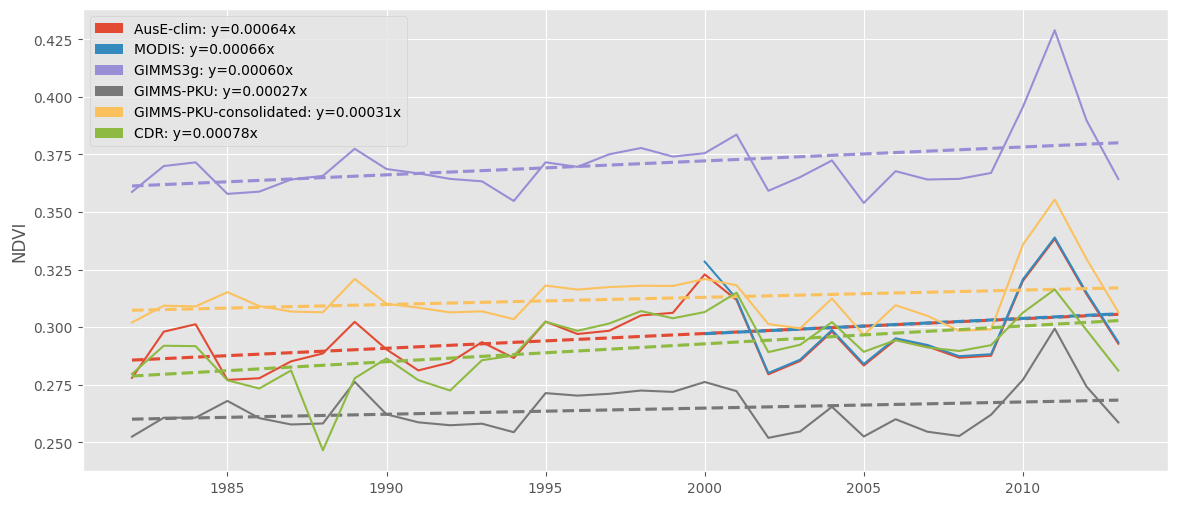

In [8]:
dss = [ds_1d, modis_1d, gimms_1d, gimms_pku_1d, gimms_pku_cons_1d, cdr_1d]
name = ['AusE-clim','MODIS','GIMMS3g','GIMMS-PKU', 'GIMMS-PKU-consolidated','CDR']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors[0:-1]

fig, ax = plt.subplots(1,1, figsize=(14,6))

slopes =[]
for xx, n, c in zip(dss, name, colors):
    
    df = xx.drop_vars('spatial_ref').to_dataframe(name=n).reset_index(drop=True)
    df.index = xx.time.dt.year.values
    df = df.reset_index()
    df = df.rename({'index':'Year'},axis=1)
    
    s, i, r, p, se = stats.linregress(df['Year'], df[n])
    slopes.append(s)
    sb.regplot(y=n, x='Year', data=df, ax=ax, ci=None, label=n, fit_reg=True, color=c,
                 line_kws={'linestyle':'--'}, #'label':"y={0:.5f}x+{1:.4f}".format(s,i), 
                 scatter_kws ={'s':0}
              )

    sb.lineplot(y=n, x='Year', data=df, ax=ax, color=c)

#legend with slopes
labels = []
for n,s in zip(name,slopes):
    labels.append(n+": y={0:.5f}x".format(s))

ax.legend(
        [Patch(facecolor=c) for c in colors], 
        labels, 
        loc='best'
    )

plt.title(None);
ax.set_xlabel(None);
ax.set_ylabel('NDVI');
fig.savefig('/g/data/os22/chad_tmp/AusENDVI/results/figs/compare_annual_average_trends.png',
            bbox_inches='tight', dpi=300)